# $p$-value and Bayesian Hypothesis Testing

In hypothesis testing, frequentists generally use *p*-value to evaluate the evidence against the null hypothesis;*Bayesian hypothesis testing, however, directly computes the probability of any hypothesis given observed data.

# Graphical Summary

![Fig](./graphical_summary/slides/Slide25.png)

# Key Formulas

The $p$-value is the probability of observing a test statistic at least as extreme as the one observed, assuming the null hypothesis is true.

$$
p\text{-value} = P(\text{Reject } H_0 | H_0 \text{ is true}) = P(T \geq t_{\text{obs}} \mid H_0)
$$

where $T$ is the test statistic and $t_{\text{obs}}$ is the observed value.

Posterior probability of hypothesis $H_i$ given data $\text{D}$:

$$
P(H_i \mid \text{D}) = \frac{P(\text{D} \mid H_i) \cdot P(H_i)}{P(\text{D})}
$$

And one can use Bayes factor to compare hypotheses $H_1$ and $H_0$: $\text{BF}_{10} = \frac{P(D \mid H_1)}{P(D \mid H_0)}$

# Technical Details

## Multiple Testing

When conducting multiple hypothesis tests, the probability of making at least one Type I error (false positive) increases. Multiple testing corrections control this inflation.

Two main correction approaches:

- **Family-Wise Error Rate (FWER)**: Controls the probability of making at least one false positive across all tests

  $$
  \alpha_{\text{Bonferroni}} = \frac{\alpha}{M}
  $$

  where $M$ is the number of tests and $\alpha$ is the desired significance level. Example: for $M = 1{,}000{,}000$ tests with $\alpha = 0.05$, the corrected threshold is $5 \times 10^{-8}$.

- **False Discovery Rate (FDR)**: Controls the expected proportion of false positives among rejected hypotheses (less stringent than FWER, thus more powerful). The Benjamini-Hochberg procedure ranks $p$-values and rejects all $H_0$ where $p_{(i)} \leq \frac{i}{M} \cdot \alpha$ for the largest such $i$.

## Permutation Test

A method for obtaining the null distribution of a test statistic by shuffling data many times to simulate pure randomness. The resulting $p$-values are called *empirical $p$-values*.

**Procedure**:
1. Calculate test statistic $T_{\text{obs}}$ on observed data
2. Randomly permute labels/outcomes $B$ times (typically $B = 10{,}000$)
3. Calculate test statistic $T_b$ for each permutation $b$
4. Compute empirical $p$-value:
   $$
   p\text{-value} = \frac{1 + \sum_{b=1}^{B} \mathbb{1}(T_b \geq T_{\text{obs}})}{B + 1}
   $$

**Advantages**:
- **Distribution-free**: No assumptions about test statistic distribution
- **Exact**: Provides exact $p$-values for finite samples
- **Flexible**: Works with any test statistic, useful when null distribution is unknown

**Limitations**:
- **Computationally intensive**: Problematic for large-scale studies (e.g., GWAS)
- **Assumes exchangeability**: Under $H_0$, observation order must be irrelevant
- **Multiple testing correction still needed**: FWER or FDR control required for many tests

## $p$-value

**Monotonic Relationship**: Smaller $p$-values correspond to more extreme test statistics.

**Decision Rule**: Reject $H_0$ if $p$-value $\leq \alpha$ (where $\alpha$ is the significance level).

**Interpretation Limit**: $H_0$ can never be "accepted" or "proven true". It can only be:
- **Rejected** ($p$-value $\leq \alpha$): Evidence against $H_0$
- **Not rejected** ($p$-value $> \alpha$): Insufficient evidence against $H_0$

Failure to reject $H_0$ does not imply $H_0$ is true. Absence of evidence is not evidence of absence.

## Bayesian Hypothesis Testing

Bayesian hypothesis testing directly computes the probability that a hypothesis is true given the observed data: $P(H_i \mid D)$. This is more intuitive than frequentist $p$-values, which condition on the hypothesis being true.

**Key advantages**:
- **Direct probability statements**: Can state "$H_1$ has 95% probability of being true given the data"
- **No multiple testing problem**: Each hypothesis evaluated independently; posterior probabilities remain valid
- **Incorporates prior knowledge**: Prior beliefs $P(H_i)$ are explicitly integrated into inference

**Bayes Factor interpretation**: The Bayes Factor $\text{BF}_{10}$ quantifies evidence strength:
- $\text{BF}_{10} > 10$: Strong evidence for $H_1$
- $\text{BF}_{10} = 1$: No evidence either way
- $\text{BF}_{10} < 0.1$: Strong evidence for $H_0$

**Limitation**: Results depend on prior specification, which can be subjective. Different priors may lead to different conclusions, especially with limited data.

## Frequentist vs. Bayesian Paradigms

**The fundamental question**: What does probability mean?

| Aspect | Frequentist | Bayesian |
|--------|-------------|----------|
| **Probability** | Long-run frequency over repeated experiments | Degree of belief/uncertainty |
| **What varies** | Data varies across hypothetical repetitions; parameters are fixed | Parameters vary; observed data is fixed |
| **Question answered** | $P(\text{Data} \mid H_0)$ — "How extreme is my data if $H_0$ were true?" | $P(H_0 \mid \text{Data})$ — "How probable is $H_0$ given my data?" |
| **Can say** | "$p$-value = 0.03" (probability of data or more extreme under $H_0$) | "There's a 95% probability the parameter is in this interval" |
| **Cannot say** | "Probability that $H_0$ is true" | "Long-run error rate is 5%" (no repeated sampling framework) |
| **Multiple testing** | Requires explicit corrections (Bonferroni, FDR) | Prior beliefs naturally regularize; no formal correction needed |

# Related Topics

- [ordinary least squares](https://statfungen.github.io/statgen-primer/ordinary_least_squares.html)
- [summary statistics](https://statfungen.github.io/statgen-primer/summary_statistics.html)
- [likelihood](https://statfungen.github.io/statgen-primer/likelihood.html)
- [Bayes factor](https://statfungen.github.io/statgen-primer/Bayes_factor.html)

# Example

In quantitative trait locus (QTL) analysis, we ask: do genetic variants affect gene expression?

**Scenario:** We have SNP genotypes and gene expression data from multiple individuals. For each SNP, we test whether different genotypes correspond to different expression levels, then correct for testing multiple SNPs.

We have genotype data for 200 individuals at 25 SNPs in a region of interest, and gene expression measurements for each individual.

## Setup

In [20]:
rm(list=ls())
set.seed(38)

n_samples <- 200
n_snps <- 25
ld_rho <- 0.8

hap1 <- hap2 <- matrix(NA, n_samples, n_snps)
hap1[, 1] <- rbinom(n_samples, 1, 0.5)
hap2[, 1] <- rbinom(n_samples, 1, 0.5)

for(i in 2:n_snps) {
  hap1[, i] <- hap1[, i-1]
  hap2[, i] <- hap2[, i-1]
  flip1 <- runif(n_samples) > ld_rho
  flip2 <- runif(n_samples) > ld_rho
  hap1[flip1, i] <- 1 - hap1[flip1, i]
  hap2[flip2, i] <- 1 - hap2[flip2, i]
}

genotypes <- hap1 + hap2
colnames(genotypes) <- paste0("SNP_", 1:n_snps)

cat("Genotype matrix:", n_samples, "samples ×", n_snps, "SNPs\n")
cat("LD parameter (rho):", ld_rho, "\n")
head(genotypes[, 1:6])

Genotype matrix: 200 samples × 25 SNPs
LD parameter (rho): 0.8 


SNP_1,SNP_2,SNP_3,SNP_4,SNP_5,SNP_6
1,1,0,0,0,1
0,0,0,0,1,2
0,0,0,1,2,2
0,1,1,1,1,1
2,2,2,2,2,2
1,1,1,1,1,1


## Simulate Gene Expression

Simulate expression with **SNP1 and SNP2 as causal variants** plus noise.

In [21]:
effect1 <- 1.5
effect2 <- 1.2

expression <- effect1 * genotypes[, 1] +
              effect2 * genotypes[, 2] +
              rnorm(n_samples, sd = 2)

cat("True effects: SNP_1 =", effect1, ", SNP_2 =", effect2, "\n")
cat("Expression: mean =", round(mean(expression), 2),
    ", SD =", round(sd(expression), 2), "\n")

True effects: SNP_1 = 1.5 , SNP_2 = 1.2 
Expression: mean = 2.85 , SD = 2.59 


## Association Testing

We first test the marginal effect of each variant: `expression ~ genotype`


In [22]:
results <- data.frame(
  SNP = colnames(genotypes),
  Effect = NA,
  T_stat = NA,
  P_value = NA
)

for(i in 1:n_snps) {
  fit <- lm(expression ~ genotypes[, i])
  coef_summary <- summary(fit)$coefficients[2, ]
  results[i, 2:4] <- coef_summary[c(1, 3, 4)]
}

results$Minus_log10_P <- -log10(results$P_value)

cat("\nNominal significance (p < 0.05):", sum(results$P_value < 0.05), "SNPs\n")
results[results$P_value < 0.05, ]


Nominal significance (p < 0.05): 4 SNPs


,SNP,Effect,T_stat,P_value,Minus_log10_P
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,SNP_1,2.0407899,10.137539,1.015866e-19,18.993164
2,SNP_2,2.2685514,11.383006,2.021029e-23,22.694427
3,SNP_3,1.5096572,6.622406,3.252300e-10,9.487809
4,SNP_4,0.6000125,2.333112,2.064614e-02,1.685161


## Multiple Testing Correction

### Bonferroni Correction

Apply Bonferroni correction: threshold = $\frac{\alpha}{M} = \frac{0.05}{25}$.

In [23]:
alpha <- 0.05
bonf_thresh <- alpha / n_snps

results$Bonf_sig <- results$P_value < bonf_thresh

cat("Bonferroni threshold:", bonf_thresh, "\n")
cat("Significant SNPs:", sum(results$Bonf_sig), "\n\n")
results[results$Bonf_sig, c("SNP", "Effect", "P_value")]

Bonferroni threshold: 0.002 
Significant SNPs: 3 



,SNP,Effect,P_value
,<chr>,<dbl>,<dbl>
1,SNP_1,2.040790,1.015866e-19
2,SNP_2,2.268551,2.021029e-23
3,SNP_3,1.509657,3.252300e-10


Bonferroni correction reduces the number of significant variants.

### Benjamini-Hochberg FDR Control


FDR controls the expected proportion of false positives among discoveries, providing more power than Bonferroni.

In [24]:
sorted_idx <- order(results$P_value)
sorted_p <- results$P_value[sorted_idx]
bh_thresh <- (1:n_snps / n_snps) * alpha

cutoff <- max(c(0, which(sorted_p <= bh_thresh)))
fdr_thresh <- ifelse(cutoff > 0, sorted_p[cutoff], 0)

results$Q_value <- p.adjust(results$P_value, method = "BH")
results$FDR_sig <- results$Q_value < alpha

cat("FDR threshold (largest p-value):", fdr_thresh, "\n")
cat("Significant SNPs:", sum(results$FDR_sig), "\n\n")
results[results$FDR_sig, c("SNP", "Effect", "P_value", "Q_value")]

FDR threshold (largest p-value): 3.2523e-10 
Significant SNPs: 3 



,SNP,Effect,P_value,Q_value
,<chr>,<dbl>,<dbl>,<dbl>
1,SNP_1,2.040790,1.015866e-19,1.269832e-18
2,SNP_2,2.268551,2.021029e-23,5.052573e-22
3,SNP_3,1.509657,3.252300e-10,2.710250e-09


## Permutation Testing for eGene Discovery

Permutation testing generates empirical p-values by shuffling sample labels to create a null distribution of the minimum p-value across all SNPs.

In [25]:
min_pval_observed <- min(results$P_value)

cat("Observed minimum p-value:", min_pval_observed, "\n\n")

n_perms <- 100
min_pvals_permuted <- numeric(n_perms)

set.seed(72)

cat("Running", n_perms, "permutations...\n")

for(perm in 1:n_perms) {
  expression_shuffled <- expression[sample(n_samples)]

  pvals_perm <- numeric(n_snps)
  for(i in 1:n_snps) {
    model <- lm(expression_shuffled ~ genotypes[, i])
    pvals_perm[i] <- summary(model)$coefficients[2, 4]
  }

  min_pvals_permuted[perm] <- min(pvals_perm)
}

cat("Permutation test completed.\n\n")

Observed minimum p-value: 2.021029e-23 

Running 100 permutations...
Permutation test completed.



Empirical p-value: 0.00990099 



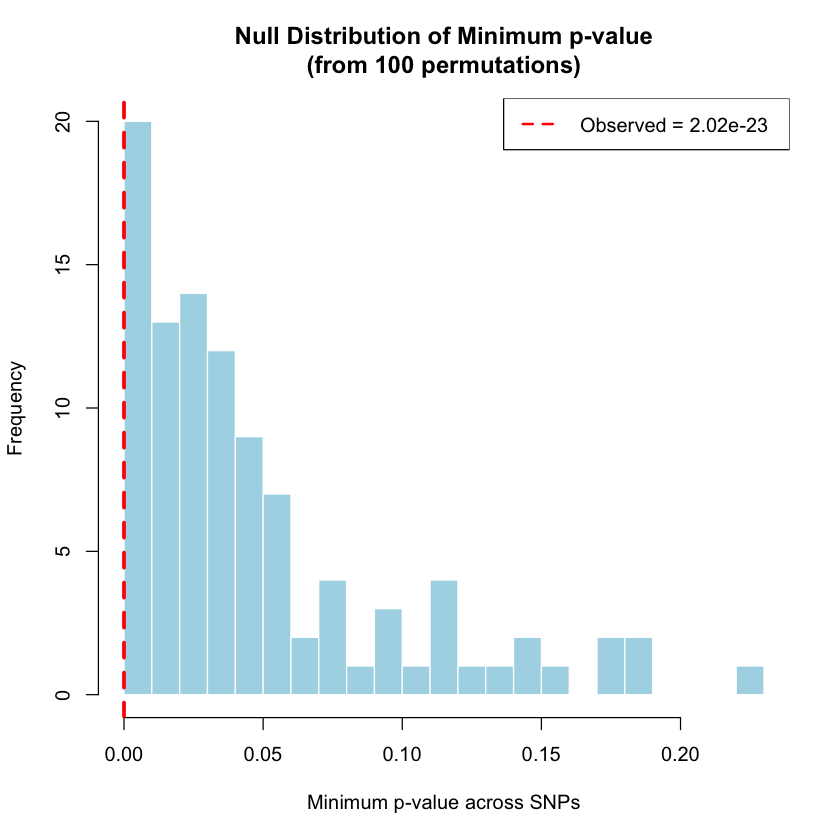

In [26]:
empirical_pval <- (1 + sum(min_pvals_permuted <= min_pval_observed)) / (n_perms + 1)

cat("Empirical p-value:", empirical_pval, "\n\n")

hist(min_pvals_permuted,
     breaks = 30,
     main = paste0("Null Distribution of Minimum p-value\n(from ", n_perms, " permutations)"),
     xlab = "Minimum p-value across SNPs",
     ylab = "Frequency",
     col = "lightblue",
     border = "white")

abline(v = min_pval_observed, col = "red", lwd = 3, lty = 2)
legend("topright",
       legend = paste("Observed =", format(min_pval_observed, scientific = TRUE, digits = 3)),
       col = "red", lty = 2, lwd = 2)


## Genome-Wide eGene Discovery: FDR Control Across Multiple Genes

**What we did for ONE gene above:**
- Tested 25 SNPs for association with expression
- Used minimum $p-value across all SNPs as the gene-level test statistic
- Permuted expression labels to generate null distribution
- Computed empirical $p$-value for the gene

**The genome-wide scenario:**

In a real eQTL study, we test thousands of genes. For each gene:
1. Test all nearby SNPs for association
2. Use permutation to get an empirical $p-value (accounting for LD between SNPs)
3. This gives us one $p-value per gene

**The multiple testing problem:** Testing many genes means we need FDR control at the gene level to determine which genes are true eGenes (genes with at least one eQTL).

Below, we simulate this scenario: our analyzed gene plus 99 other genes, then apply FDR.

In [27]:
n_genes <- 100

cat("Simulating genome-wide eQTL study:\n")
cat("===================================\n\n")

cat("Gene_1 (our analyzed gene):\n")
cat("  Empirical p-value:", format(empirical_pval, scientific=TRUE), "\n\n")

set.seed(72)
other_genes_pval <- rbeta(n_genes - 1, shape1 = 1, shape2 = 5)

all_genes_pval <- c(empirical_pval, other_genes_pval)
gene_names <- paste0("Gene_", 1:n_genes)

cat("Simulated empirical p-values for", n_genes - 1, "other genes\n")
cat("(most genes have no eQTL, so p-values are uniformly distributed)\n\n")

cat("Distribution of empirical p-values across all", n_genes, "genes:\n")
cat("  Smallest:", format(min(all_genes_pval), scientific=TRUE), "\n")
cat("  Median:", round(median(all_genes_pval), 3), "\n")
cat("  Largest:", round(max(all_genes_pval), 3), "\n\n")

Simulating genome-wide eQTL study:

Gene_1 (our analyzed gene):
  Empirical p-value: 9.90099e-03 

Simulated empirical p-values for 99 other genes
(most genes have no eQTL, so p-values are uniformly distributed)

Distribution of empirical p-values across all 100 genes:
  Smallest: 4.125328e-04 
  Median: 0.121 
  Largest: 0.572 



Apply Benjamini-Hochberg FDR control to identify significant eGenes.

In [28]:
sorted_idx <- order(all_genes_pval)
sorted_pval <- all_genes_pval[sorted_idx]

alpha_fdr <- 0.05
bh_thresh <- (1:n_genes / n_genes) * alpha_fdr

sig_idx <- which(sorted_pval <= bh_thresh)
n_sig <- ifelse(length(sig_idx) > 0, max(sig_idx), 0)

q_values <- p.adjust(all_genes_pval, method = "BH")

results <- data.frame(
  Gene = gene_names,
  Empirical_P = all_genes_pval,
  Q_value = q_values,
  Significant = q_values < alpha_fdr
)

cat("FDR control results (q-value < 0.05):\n")
cat("======================================\n\n")

sig_genes <- results[results$Significant, ]
if(nrow(sig_genes) > 0) {
  print(sig_genes[order(sig_genes$Q_value), ])
  cat("\nSignificant eGenes:", nrow(sig_genes), "\n")
  cat("Expected false positives: ~", round(nrow(sig_genes) * 0.05, 1), "\n\n")
} else {
  cat("No significant eGenes found at FDR 0.05\n\n")
}

cat("Gene_1 (our analyzed gene):", 
    ifelse("Gene_1" %in% sig_genes$Gene, "SIGNIFICANT", "not significant"), "\n")


FDR control results (q-value < 0.05):

      Gene  Empirical_P    Q_value Significant
34 Gene_34 0.0004125328 0.04125328        TRUE

Significant eGenes: 1 
Expected false positives: ~ 0 

Gene_1 (our analyzed gene): not significant 


**Note:** Genes 2-100 are simulated to illustrate the workflow. In a real study, each gene would have its own permutation test performed independently.

# Supplementary

## Graphical Summary

### p-value: Right Tail Probability

Visualizing the p-value as the area in the right tail of the null distribution:

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


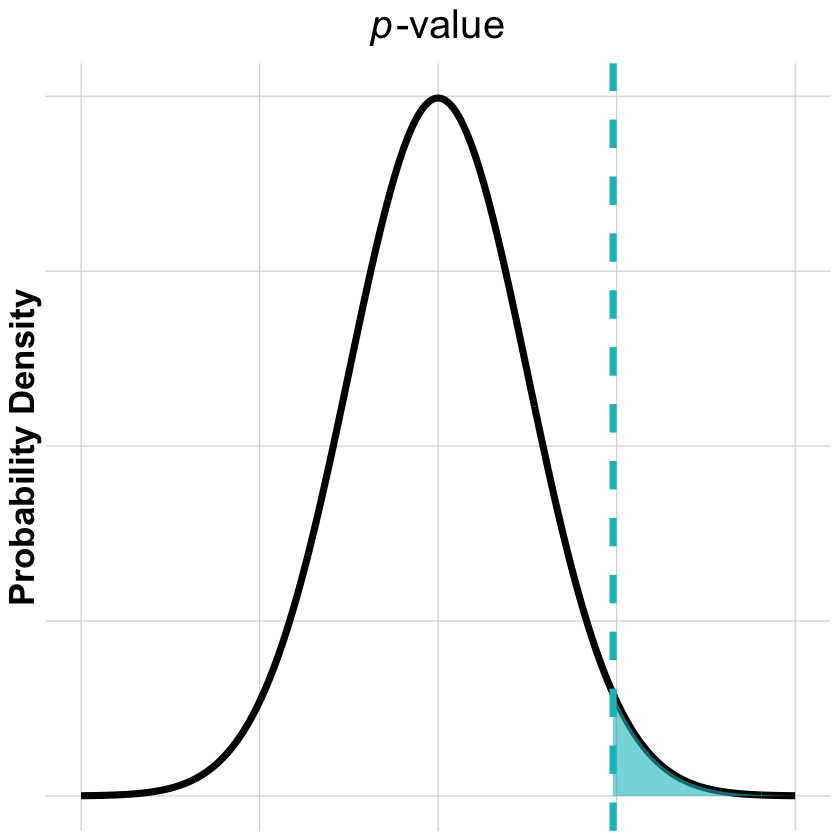

In [29]:
library(ggplot2)
library(tibble)
# Create data for a normal distribution curve
x_range <- seq(-4, 4, by = 0.01)
curve_data <- tibble(x = x_range, density = dnorm(x_range, mean = 0, sd = 1))
# Define the vertical line position (e.g., at x = 1.96 for a typical significance level)
line_pos <- 1.96
# Create data for the shaded area (from line to the right)
shade_data <- curve_data[curve_data$x >= line_pos, ]
# Create the plot
p_value_plot <- ggplot(curve_data, aes(x = x, y = density)) +
  geom_line(color = "black", linewidth = 2) +
  geom_area(data = shade_data, fill = "#00BFC4", alpha = 0.6) +
  geom_vline(xintercept = line_pos, color = "#00BFC4", linewidth = 2, linetype = "dashed") +
  labs(
    title = expression(italic(p)*"-value"),
    y = "Probability Density"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 24, face = "bold", hjust = 0.5),
    axis.title.x = element_blank(),
    axis.title.y = element_text(size = 21, face = "bold"),
    axis.text = element_blank(),
    legend.position = "top",
    legend.title = element_text(size = 23, face = "bold"),
    legend.text = element_text(size = 22, face = "bold"),
    panel.grid.major = element_line(color = "lightgray", size = 0.3),
    panel.grid.minor = element_blank(),
    panel.background = element_rect(fill = "transparent", color = NA),
    plot.background = element_rect(fill = "transparent", color = NA)
  )

print(p_value_plot)
ggsave("./figures/p_value.png", plot = p_value_plot, width = 12, height = 6, 
       units = "in", dpi = 300, bg = "transparent")

### Bayesian Hypothesis Testing

In Bayesian hypothesis testing, we compare two hypotheses by calculating their posterior probabilities given the observed data. Below we visualize this with two overlapping normal distributions:

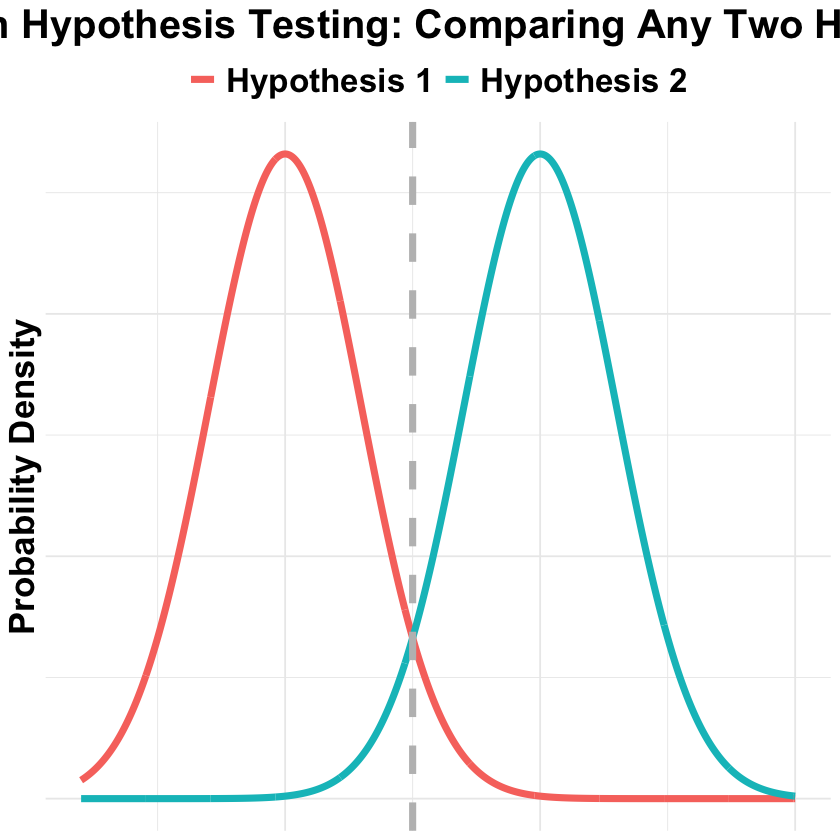

In [30]:
library(ggplot2)
library(tibble)

# Create data for two hypothesis
x_range <- seq(-4, 10, by = 0.01)

h0_data <- tibble(
  x = x_range,
  density = dnorm(x_range, mean = 0, sd = 1.5),
  hypothesis = "Hypothesis 1"
)

h1_data <- tibble(
  x = x_range,
  density = dnorm(x_range, mean = 5, sd = 1.5),
  hypothesis = "Hypothesis 2"
)

line_pos = (0+5)/2
bayes_data <- rbind(h0_data, h1_data)

# Create the plot
p_Bayesian_hypothesis_testing <- ggplot(bayes_data, aes(x = x, y = density, color = hypothesis)) +
  geom_line(linewidth = 2) +
  geom_vline(xintercept = line_pos, color = "grey", linewidth = 2, linetype = "dashed") +
  labs(
    title = "Bayesian Hypothesis Testing: Comparing Any Two Hypotheses",
    x = "Test Statistic",
    y = "Probability Density",
    color = NULL
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 24, face = "bold", hjust = 0.5),
    axis.title = element_text(size = 21, face = "bold"),
    axis.title.x = element_blank(),
    axis.text = element_blank(),
    legend.position = "top",
    legend.title = element_text(size = 24, face = "bold"),
    legend.text = element_text(size = 20, face = "bold"),
    panel.background = element_rect(fill = "transparent", color = NA),
    plot.background = element_rect(fill = "transparent", color = NA)
  )

print(p_Bayesian_hypothesis_testing)
ggsave("./figures/Bayesian_hypothesis_testing.png", plot = p_Bayesian_hypothesis_testing, width = 12, height = 6,
       units = "in", dpi = 300, bg = "transparent")


### Multiple Testing

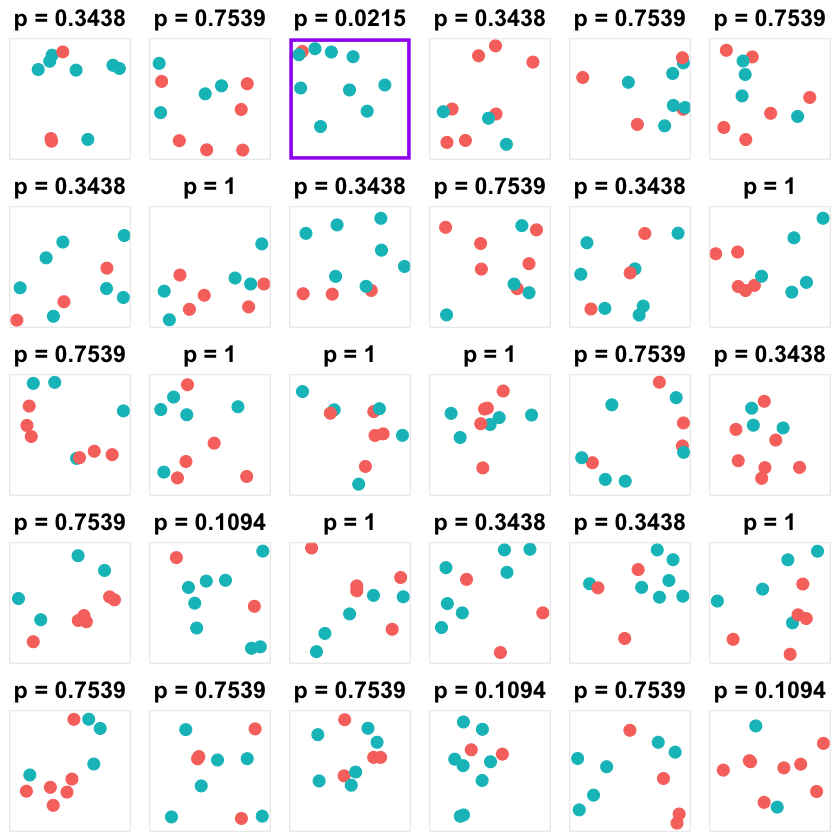

In [31]:
library(ggplot2)
library(tibble)
library(gridExtra)

# Set seed for reproducibility
set.seed(71)

# Function to generate random sample of 10 dots (blue or red with equal probability)
generate_sample <- function(n = 10) {
  tibble(
    x = runif(n, 0, 1),
    y = runif(n, 0, 1),
    color = sample(c("red", "blue"), n, replace = TRUE, prob = c(0.5, 0.5))
  )
}

# Function to calculate p-value using binomial test
calc_binomial_pvalue <- function(data) {
  n_blue <- sum(data$color == "blue")
  n_total <- nrow(data)
  # Two-tailed binomial test
  binom.test(n_blue, n_total, p = 0.5, alternative = "two.sided")$p.value
}

# Generate 30 samples
n_samples <- 30
sample_list <- list()

for (i in 1:n_samples) {
  data <- generate_sample(n = 10)
  pval <- calc_binomial_pvalue(data)
  sample_list[[i]] <- list(data = data, pval = pval)
}

# Create a grid of plots
plot_list <- lapply(1:n_samples, function(i) {
  data <- sample_list[[i]]$data
  pval <- sample_list[[i]]$pval
  
  # Count blue and red
  n_blue <- sum(data$color == "blue")
  n_red <- sum(data$color == "red")
  
  # Format p-value
  pval_text <- paste0("p = ", round(pval, 4))
  
  # Highlight significant comparisons (p < 0.05)
  border_color <- if (pval < 0.05) "purple" else "gray90"
  border_size <- if (pval < 0.05) 2 else 0.5
  
  ggplot(data, aes(x = x, y = y, color = color)) +
    geom_point(size = 3) +
    scale_color_manual(values = c("red" = "#F8766D", "blue" = "#00BFC4")) +
    labs(title = pval_text) +
    theme_void() +
    theme(
      plot.title = element_text(size = 14, hjust = 0.5, face = "bold", margin = margin(b = 5)),
      legend.position = "none",
      panel.border = element_rect(color = border_color, fill = NA, linewidth = border_size),
      plot.background = element_rect(fill = "transparent", color = NA),
      panel.background = element_rect(fill = "transparent", color = NA),
      plot.margin = margin(5, 5, 5, 5)
    ) +
    coord_fixed(xlim = c(0, 1), ylim = c(0, 1))
})

# Arrange in a grid (5 rows x 6 columns)
grid_plot <- grid.arrange(grobs = plot_list, ncol = 6)

# Save
ggsave("./figures/multiple_testing.png", plot = grid_plot, 
       width = 18, height = 10, units = "in", dpi = 300, bg = "transparent")

# Extended Reading

- [Connection between Bayes factor and p-value](https://stephens999.github.io/fiveMinuteStats/BF_and_pvalue.html)
- [Example of difficulty of calibrating p values](https://stephens999.github.io/fiveMinuteStats/pvalue_difficult_calibrate_example.html)